<a href=https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/cross_decomposition/pls_.py#L455> Код из sklearn </a>

In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

% matplotlib inline

## Код генерации датасетов

Взято у Романа:

In [13]:
def generate_collinear_features(n, X):
    '''Makes features correlated'''
    n_features = X.shape[1]
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        if n_features / 3 >= 2:
            n_cols = max(2, np.random.randint(n_features / 3) + 1)
        else:
            n_cols = 2
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        X_new[:, i] = X[:, col_idxs].dot(coef) 
    return X_new

In [3]:
def generate_y(X, coeffs=None, n_cols=3, noise=True):
    '''Generates y'''
    if coeffs is None:
        coeffs = sps.expon.rvs(size=(X.shape[1], n_cols)) # some_matrix just for testing
    ans = X @ coeffs
    if noise:
        error = sps.norm.rvs(scale=0.5, size=ans.shape)
    else:
        error = 0
    y = ans + error
    return y

In [4]:
def generate_correlated_data(n_samples, n_features, p=0.5, draw=True, coeffs=None):
    '''Generates correlated data'''
    start_n_features = int(p * n_features)
    X = sps.norm.rvs(size=(n_samples, start_n_features))
    X_col = generate_collinear_features(n_features - start_n_features, X)
    X = np.hstack([X, X_col])
    if draw:
        plt.figure(figsize=(6, 5))
        plt.imshow(np.corrcoef(X.T))
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=16) 
        plt.tight_layout()
        plt.show()
    y = generate_y(X, coeffs) # here can be something else
    return X, y

In [21]:
def get_ortho_to2(X):
    v = np.cross(X[:, 0], X[:, 1])
    return v / np.linalg.norm(v)

## Тестирование PLS из sklearn

In [7]:
import pls_

In [8]:
def rmse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)

In [9]:
from sklearn.model_selection import train_test_split

def get_test_train(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1360)
    return X_train, X_test, y_train, y_test

**Тест:** генерируется $X$ размерности 3, по большей части, содержащийся в одной плоскости, и $Y$ размерности 1.

In [23]:
from scipy.stats import ortho_group

def x3(n_samples, noise=True, n_cols=1):
    basis = ortho_group.rvs(3)
    X = generate_collinear_features(3, sps.norm.rvs(size=(n_samples, 2)))
    X = X @ basis
    if noise:
        error = sps.norm.rvs(scale=X.std(axis=0)/2, size=X.shape)
        X += error
    y = generate_y(X, coeffs=None, n_cols=n_cols, noise=True)
    return basis, X, y

Изображена выборка и базис, в котором она располагается, 

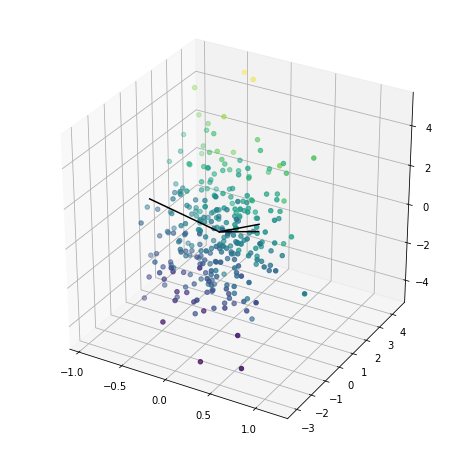

In [153]:
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(100)
basis, X, y = x3(300)
X_train, X_test, y_train, y_test = get_test_train(X, y)

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])
for i in range(3):
    v = basis[:, i]
    ax1.plot([0, v[0]], [0, v[1]], [0, v[2]], color='black')
plt.show()

Применяем PLS с изначальными метками $y$ и случайными метками.

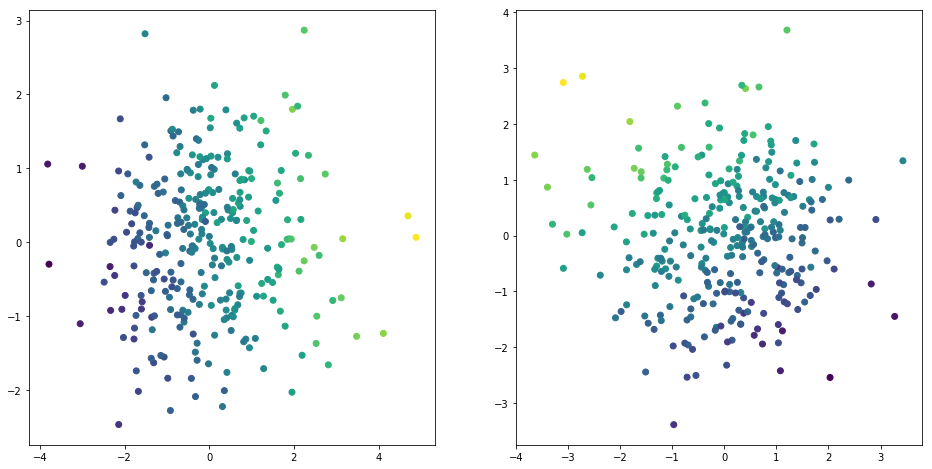

In [145]:
np.random.seed(177)

regr = pls_.PLSRegression()
regr.fit(X_train, y_train[:, 0])
new_X = regr.transform(X)

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(new_X[:, 0], new_X[:, 1], c=y[:, 0])

regr1 = pls_.PLSRegression()
regr1.fit(X_train, sps.norm.rvs(scale=0.5, size=X_train.shape[0]))

plt.subplot(1, 2, 2)
new_X1 = regr1.transform(X)
plt.scatter(new_X1[:, 0], new_X1[:, 1], c=y[:, 0])
plt.show()

Получаются довольно похожие графики (с учетом поворота плоскости), но это, очевидно, потому, что есть всего 2 значащих измерения. Это видно и по нормальной компоненте к компонентам `x_loadings_` --- недостающей компоненте перехода из скрытого пространства в исходное.

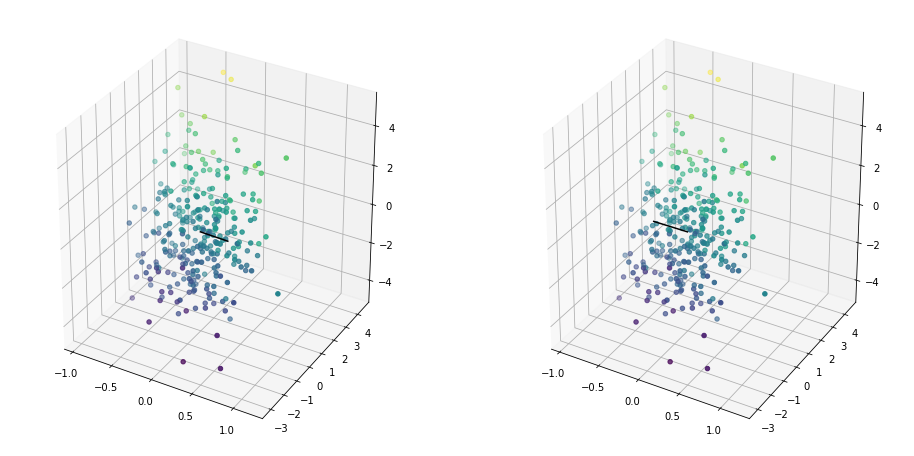

In [155]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])
v = get_ortho_to2(regr.x_loadings_)
ax1.plot([0, v[0]], [0, v[1]], [0, v[2]], color='black')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])
v1 = get_ortho_to2(regr1.x_loadings_)
ax2.plot([0, v1[0]], [0, v1[1]], [0, v1[2]], color='black')
plt.show()

In [70]:
regr.x_weights_

array([[ 0.94533002, -0.32596702],
       [ 0.26072413,  0.77354204],
       [ 0.19589303,  0.54348709]])

Ошибка RMSE предсказания:

In [150]:
rmse(y_test, regr.predict(X_test))

0.11380496153790846

**Тест:** генерируется $X$ размерности 3, по большей части, содержащийся в одной плоскости, и $Y$ размерности 2.

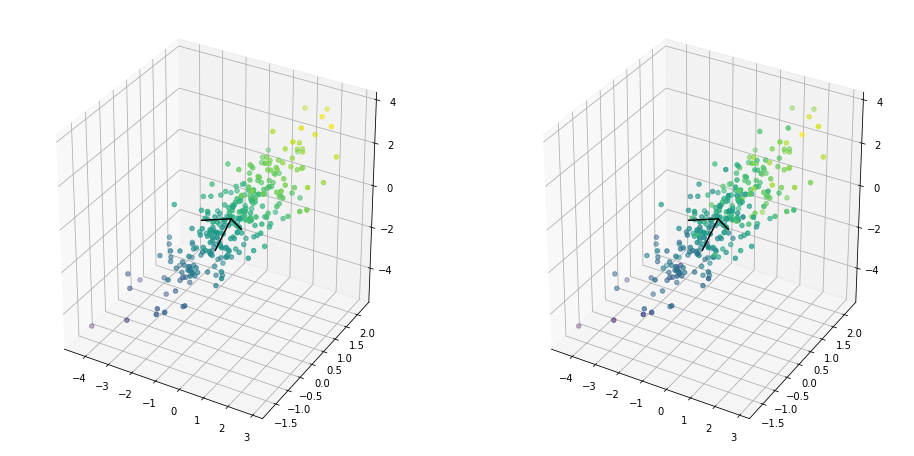

In [60]:
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(156)
basis, X, y = x3(300, n_cols=2)
X_train, X_test, y_train, y_test = get_test_train(X, y)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])
for i in range(3):
    v = basis[:, i]
    ax1.plot([0, v[0]], [0, v[1]], [0, v[2]], color='black')
    
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 1])
for i in range(3):
    v = basis[:, i]
    ax2.plot([0, v[0]], [0, v[1]], [0, v[2]], color='black')
plt.show()

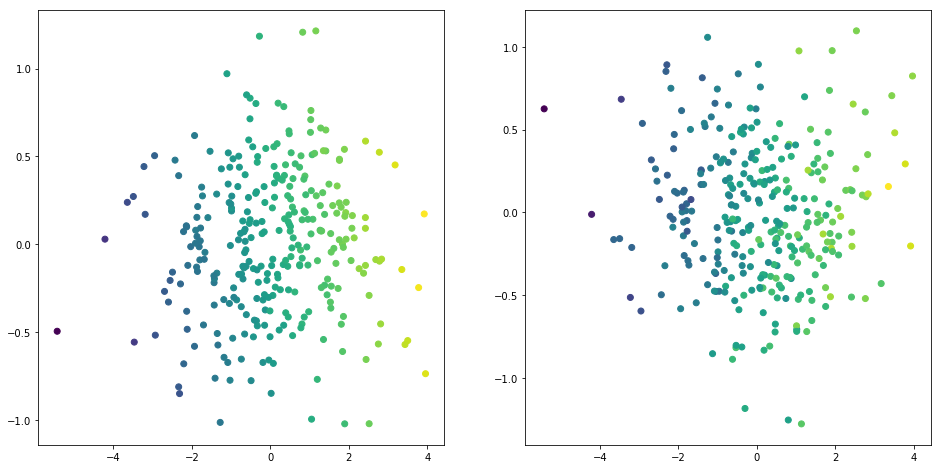

In [63]:

regr = pls_.PLSRegression()
regr.fit(X_train, y_train[:, 0])
new_X = regr.transform(X)

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(new_X[:, 0], new_X[:, 1], c=y[:, 0])

regr1 = pls_.PLSRegression()
regr1.fit(X_train, y_train[:, 1])

plt.subplot(1, 2, 2)
new_X1 = regr1.transform(X)
plt.scatter(new_X1[:, 0], new_X1[:, 1], c=y[:, 1])
plt.show()

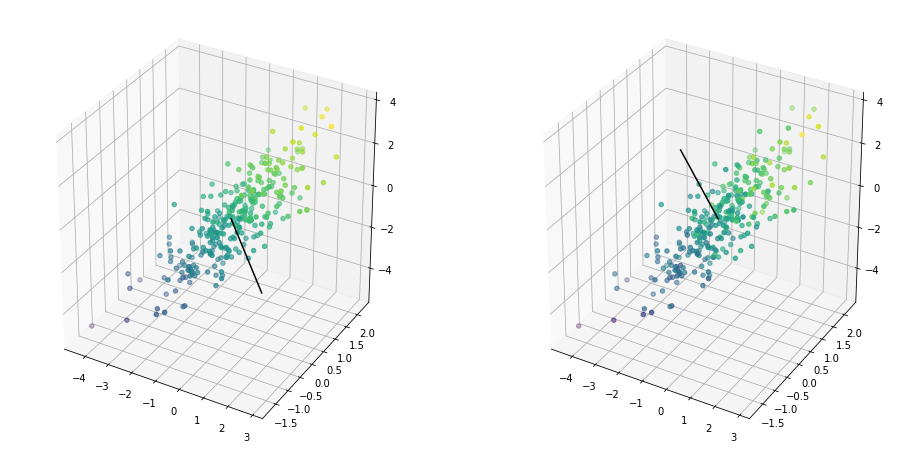

In [64]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])
v = get_ortho_to2(regr.x_loadings_) * 3
ax1.plot([0, v[0]], [0, v[1]], [0, v[2]], color='black')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 1])
v1 = get_ortho_to2(regr1.x_loadings_) * 3
ax2.plot([0, v1[0]], [0, v1[1]], [0, v1[2]], color='black')
plt.show()

**Тест:** генерируется $X$ размерности 3 и $Y$ размерности 2.

In [65]:
np.random.seed(67)
X = sps.norm.rvs(size=(1000, 3))
y = generate_y(X, coeffs=None, n_cols=2, noise=True)

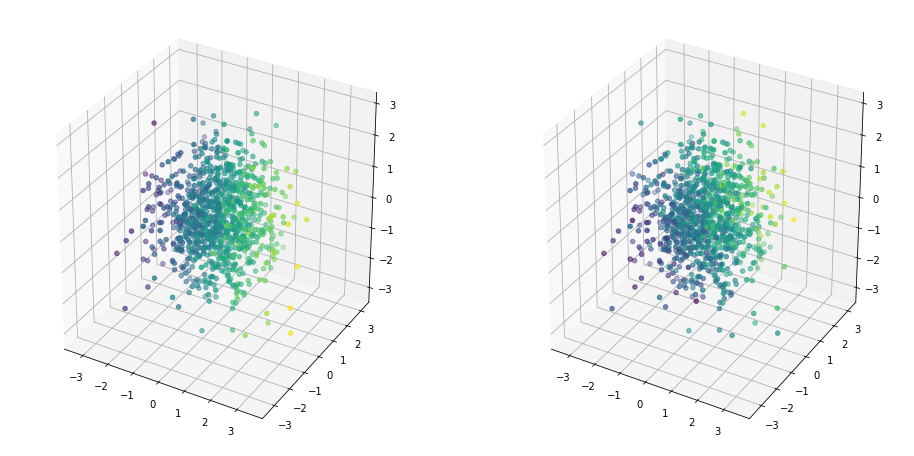

In [66]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0])

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 1])


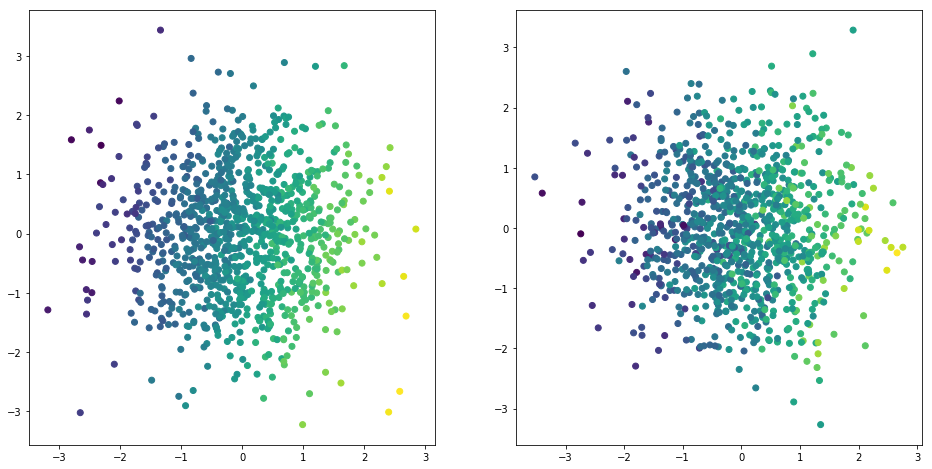

In [67]:
X_train, X_test, y_train, y_test = get_test_train(X, y)

regr = pls_.PLSRegression()
regr.fit(X_train, y_train)
new_X = regr.transform(X)

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(new_X[:, 0], new_X[:, 1], c=y[:, 0])

regr1 = pls_.PLSRegression()
regr1.fit(X_train, y_train[:, 1])

plt.subplot(1, 2, 2)
new_X1 = regr1.transform(X)
plt.scatter(new_X1[:, 0], new_X1[:, 1], c=y[:, 1])
plt.show()

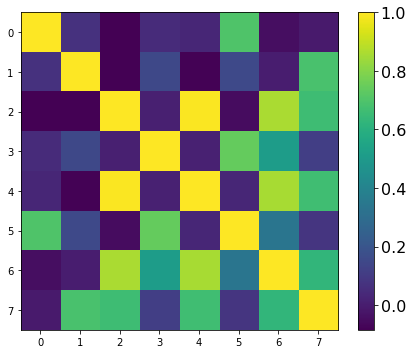

In [45]:
np.random.seed(42)
X, y = generate_correlated_data(50, 8)
X_train, X_test, y_train, y_test = get_test_train(X, y)